In [14]:
# ===================== 1. IMPORTURI ȘI CĂI =====================
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf


BASE_DIR = r"C:\Users\Alexandra\Downloads\archive (3)\Respiratory_Sound_Database"

AUDIO_DIR = os.path.join(BASE_DIR, "audio_and_txt_files")
DIAGNOSIS_PATH = os.path.join(BASE_DIR, "patient_diagnosis.csv")
EXTRA_DIR = os.path.join(BASE_DIR, "extra_data")  # COPD / Healthy / Pneumonia

print("BASE_DIR conține:", os.listdir(BASE_DIR))
print("Primele fișiere audio:", os.listdir(AUDIO_DIR)[:10])

# Citim fișierul cu diagnostice
diag_df = pd.read_csv(DIAGNOSIS_PATH)
print("Coloane în patient_diagnosis.csv:", diag_df.columns.tolist())

PID_COL = diag_df.columns[0]   # prima coloană = ID pacient
DIAG_COL = diag_df.columns[1]  # a doua coloană = diagnostic

display(diag_df.head())
print("PID_COL =", PID_COL, "DIAG_COL =", DIAG_COL)



BASE_DIR conține: ['audio_and_txt_files', 'demographic_info.txt', 'extra_data', 'filename_differences.txt', 'filename_format.txt', 'patient_diagnosis.csv']
Primele fișiere audio: ['101_1b1_Al_sc_Meditron.txt', '101_1b1_Al_sc_Meditron.wav', '101_1b1_Pr_sc_Meditron.txt', '101_1b1_Pr_sc_Meditron.wav', '102_1b1_Ar_sc_Meditron.txt', '102_1b1_Ar_sc_Meditron.wav', '103_2b2_Ar_mc_LittC2SE.txt', '103_2b2_Ar_mc_LittC2SE.wav', '104_1b1_Al_sc_Litt3200.txt', '104_1b1_Al_sc_Litt3200.wav']
Coloane în patient_diagnosis.csv: ['101', 'URTI']


,101,URTI
0,102,Healthy
1,103,Asthma
2,104,COPD
3,105,URTI
4,106,COPD


PID_COL = 101 DIAG_COL = URTI


In [15]:
# ===================== 2. PARSARE NUME FIȘIER + DATE ORIGINALE =====================

def parse_filename(fname):
    """
    Extrage ID-ul pacientului din numele fișierului.
    Exemplu: 101_1b1_Al_sc_Litt3200.wav -> patient_id = 101
    """
    name, _ = os.path.splitext(fname)
    parts = name.split('_')
    try:
        return int(parts[0])
    except:
        return None  # dacă numele fișierului nu începe cu ID pacient


# Inițializăm lista rows (în ea punem toate înregistrările)
rows = []

# Parcurgem fișierele audio originale din datasetul principal
audio_files = [f for f in os.listdir(AUDIO_DIR) if f.lower().endswith(".wav")]
print(f"Fișiere WAV găsite în datasetul original: {len(audio_files)}")

for fname in audio_files:
    patient_id = parse_filename(fname)
    
    # dacă nu putem extrage ID-ul → ignorăm fișierul
    if patient_id is None:
        continue
    
    # căutăm diagnosticul corespunzător în fișierul CSV
    diag_row = diag_df[diag_df[PID_COL] == patient_id]
    
    if diag_row.empty:
        # dacă nu există diagnostic pentru acel ID → îl ignorăm
        continue
    
    diagnosis = diag_row[DIAG_COL].iloc[0]
    
    # adăugăm rând în structura rows
    rows.append({
        "filepath": os.path.join(AUDIO_DIR, fname),
        "patient_id": patient_id,
        "diagnosis": diagnosis
    })

print("Număr fișiere originale încărcate în rows:", len(rows))


Fișiere WAV găsite în datasetul original: 920
Număr fișiere originale încărcate în rows: 918


In [16]:
# ===================== 3. DATE EXTRA (COPD / Healthy / Pneumonia) =====================

extra_count = 0

if os.path.exists(EXTRA_DIR):
    print("Folder extra_data găsit. Se adaugă fișiere suplimentare...\n")

    for folder in os.listdir(EXTRA_DIR):
        folder_path = os.path.join(EXTRA_DIR, folder)

        # ignorăm fișiere sau foldere inutile
        if not os.path.isdir(folder_path):
            continue
        if folder.startswith(".") or folder.startswith("__"):
            continue

        diagnosis = folder.strip()  # numele folderului ESTE numele diagnosticului
        wav_files = [f for f in os.listdir(folder_path) if f.lower().endswith(".wav")]

        print(f"> {diagnosis} – {len(wav_files)} fișiere găsite")

        for fname in wav_files:
            rows.append({
                "filepath": os.path.join(folder_path, fname),
                "patient_id": None,
                "diagnosis": diagnosis
            })
            extra_count += 1
    
    print(f"\nTotal fișiere adăugate din extra_data: {extra_count}")

else:
    print("Nu există folder extra_data – se folosesc doar datele originale.")

print("\nNumăr total fișiere (original + extra):", len(rows))


Folder extra_data găsit. Se adaugă fișiere suplimentare...

> COPD – 94 fișiere găsite
> Healthy – 68 fișiere găsite
> Pneumonia – 74 fișiere găsite

Total fișiere adăugate din extra_data: 236

Număr total fișiere (original + extra): 1154


In [17]:
# ===================== 4. DATAFRAME FINAL =====================

data_df = pd.DataFrame(rows)

print("DataFrame creat din rows. Dimensiune:", data_df.shape)

# Afișăm primele exemple
display(data_df.head())

# Verificăm dacă există valori lipsă
print("\nValori lipsă în DataFrame:")
print(data_df.isnull().sum())

# Distribuția pe clase (ordonată descrescător)
print("\nNumăr de exemple pe diagnostic (ordonat):")
print(data_df["diagnosis"].value_counts().sort_values(ascending=False))

# Afișăm lista de diagnostice detectate
print("\nDiagnoze detectate în setul de date:")
print(sorted(data_df["diagnosis"].unique()))


DataFrame creat din rows. Dimensiune: (1154, 3)


,filepath,patient_id,diagnosis
0,C:\Users\Alexandra\Downloads\archive (3)\Respi...,102.0,Healthy
1,C:\Users\Alexandra\Downloads\archive (3)\Respi...,103.0,Asthma
2,C:\Users\Alexandra\Downloads\archive (3)\Respi...,104.0,COPD
3,C:\Users\Alexandra\Downloads\archive (3)\Respi...,104.0,COPD
4,C:\Users\Alexandra\Downloads\archive (3)\Respi...,104.0,COPD



Valori lipsă în DataFrame:
filepath        0
patient_id    236
diagnosis       0
dtype: int64

Număr de exemple pe diagnostic (ordonat):
diagnosis
COPD              887
Pneumonia         111
Healthy           103
URTI               21
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64

Diagnoze detectate în setul de date:
['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']


In [21]:
# ===================== 5. FILTRARE CLASE RARE ( <2 exemple ) =====================

print("Distribuție pe clase înainte de filtrare:\n")
class_counts = data_df["diagnosis"].value_counts()
print(class_counts)

# Selectăm clasele cu minim 2 exemple (altfel train_test_split va da eroare)
classes_ok = class_counts[class_counts >= 3].index.tolist()

print("\nClase păstrate (>=2 exemple):")
print(classes_ok)

# Filtrăm DataFrame-ul
data_df = data_df[data_df["diagnosis"].isin(classes_ok)].reset_index(drop=True)

print("\nDistribuție pe clase DUPĂ filtrare:\n")
print(data_df["diagnosis"].value_counts())

print("\nNumăr total de înregistrări după filtrare:", len(data_df))



Distribuție pe clase înainte de filtrare:

diagnosis
COPD              887
Pneumonia         111
Healthy           103
URTI               21
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Name: count, dtype: int64

Clase păstrate (>=2 exemple):
['COPD', 'Pneumonia', 'Healthy', 'URTI', 'Bronchiectasis', 'Bronchiolitis']

Distribuție pe clase DUPĂ filtrare:

diagnosis
COPD              887
Pneumonia         111
Healthy           103
URTI               21
Bronchiectasis     16
Bronchiolitis      13
Name: count, dtype: int64

Număr total de înregistrări după filtrare: 1151


In [22]:
# ===================== 6. AUDIO -> LOG-MEL SPECTROGRAM =====================

N_MELS = 128
MAX_LEN = 256  # număr de "coloane" (timp) la care tăiem / pad-uim

def audio_to_melspec(path, n_mels=N_MELS, max_len=MAX_LEN):
    y, sr = librosa.load(path, sr=22050)
    y = librosa.util.normalize(y)

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)

    # pad/tăiere la dimensiune fixă pe axa timp
    if S_db.shape[1] < max_len:
        pad_width = max_len - S_db.shape[1]
        S_db = np.pad(S_db, ((0, 0), (0, pad_width)), mode="constant")
    else:
        S_db = S_db[:, :max_len]

    return S_db

Clase disponibile în data_df:
diagnosis
COPD              887
Pneumonia         111
Healthy           103
URTI               21
Bronchiectasis     16
Bronchiolitis      13
Name: count, dtype: int64

Exemplu Healthy/Normal: C:\Users\Alexandra\Downloads\archive (3)\Respiratory_Sound_Database\audio_and_txt_files\159_1b1_Pr_sc_Meditron.wav (Healthy)
Exemplu Boală:          C:\Users\Alexandra\Downloads\archive (3)\Respiratory_Sound_Database\audio_and_txt_files\162_2b2_Ar_mc_AKGC417L.wav (COPD)


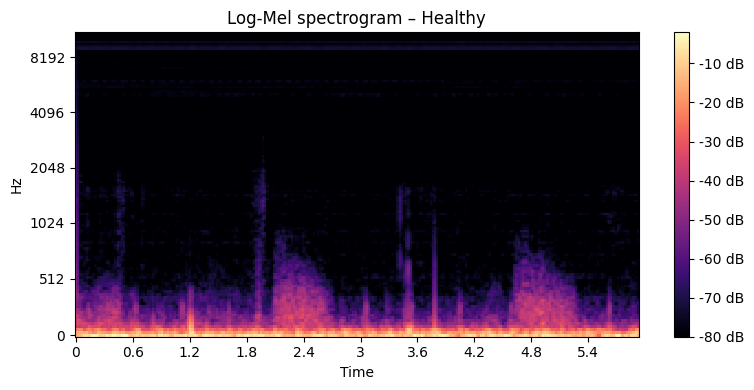

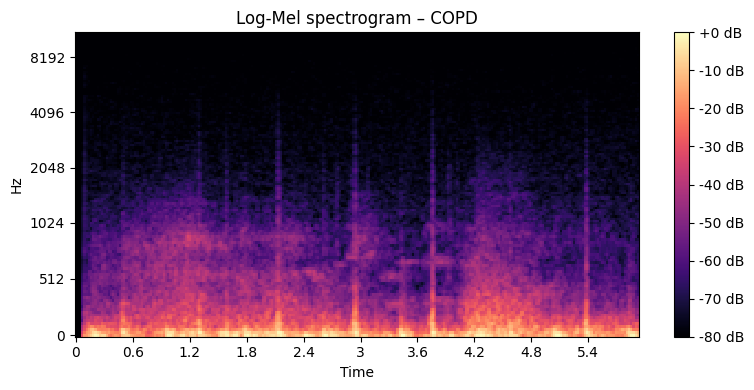

In [23]:
# ===================== 7. EXEMPLE SPECTROGRAME (HEALTHY vs BOALĂ) =====================
import librosa.display

print("Clase disponibile în data_df:")
print(data_df["diagnosis"].value_counts())

# încercăm să găsim înregistrări Healthy sau Normal
healthy_candidates = data_df[data_df["diagnosis"].isin(["Healthy", "Normal"])]

if len(healthy_candidates) == 0:
    print("\nNu există înregistrări etichetate Healthy/Normal, folosim cea mai frecventă clasă ca 'normal'.")
    most_common = data_df["diagnosis"].value_counts().idxmax()
    healthy_candidates = data_df[data_df["diagnosis"] == most_common]

healthy_row = healthy_candidates.sample(1).iloc[0]
healthy_fp = healthy_row["filepath"]
healthy_label = healthy_row["diagnosis"]

# alegem o clasă „bolnavă”, diferită de healthy_label
disease_candidates = data_df[data_df["diagnosis"] != healthy_label]
disease_label = disease_candidates["diagnosis"].value_counts().idxmax()
disease_row = disease_candidates[disease_candidates["diagnosis"] == disease_label].sample(1).iloc[0]
disease_fp = disease_row["filepath"]

print(f"\nExemplu Healthy/Normal: {healthy_fp} ({healthy_label})")
print(f"Exemplu Boală:          {disease_fp} ({disease_label})")

def plot_melspec_example(path, title, n_mels=N_MELS, max_len=MAX_LEN):
    S_db = audio_to_melspec(path, n_mels=n_mels, max_len=max_len)
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(S_db, sr=22050, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_melspec_example(healthy_fp, f"Log-Mel spectrogram – {healthy_label}")
plot_melspec_example(disease_fp, f"Log-Mel spectrogram – {disease_label}")



In [24]:
# ===================== 7. CONSTRUCȚIE X, y =====================

# etichete numerice
le = LabelEncoder()
y = le.fit_transform(data_df["diagnosis"].values)
classes = le.classes_
num_classes = len(classes)

print("Clasele modelului:", classes)
print("Număr de clase:", num_classes)

# spectrograme
X_list = []
for fp in data_df["filepath"].values:
    spec = audio_to_melspec(fp)          # (N_MELS, MAX_LEN)
    X_list.append(spec)

X = np.stack(X_list, axis=0)             # (N, N_MELS, MAX_LEN)
X = X[..., np.newaxis]                   # (N, N_MELS, MAX_LEN, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)


Clasele modelului: ['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
Număr de clase: 6
X shape: (1151, 128, 256, 1)
y shape: (1151,)


In [25]:
# ===================== 8. X, y + ÎMPĂRȚIRE TRAIN / VALIDATION / TEST =====================

# 1) etichete numerice cu LabelEncoder
le = LabelEncoder()
y_all = le.fit_transform(data_df["diagnosis"].values)
classes = le.classes_
print("Clasele modelului:", classes)
print("Număr de clase:", len(classes))

# 2) generăm spectrogramele pentru toate fișierele
X_list = []
for fp in data_df["filepath"].values:
    spec = audio_to_melspec(fp)
    X_list.append(spec)

X_all = np.stack(X_list, axis=0)      # (N, N_MELS, MAX_LEN)
X_all = X_all[..., np.newaxis]        # (N, N_MELS, MAX_LEN, 1)

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)

# 3) împărțim în train / temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all,
    test_size=0.3,
    random_state=42,
    stratify=y_all
)

# 4) împărțim temp în val / test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

num_classes = len(np.unique(y_all))
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat   = tf.keras.utils.to_categorical(y_val,   num_classes)
y_test_cat  = tf.keras.utils.to_categorical(y_test,  num_classes)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Clasele modelului: ['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
Număr de clase: 6
X_all shape: (1151, 128, 256, 1)
y_all shape: (1151,)
Train: (805, 128, 256, 1) Val: (173, 128, 256, 1) Test: (173, 128, 256, 1)


In [26]:
# ===================== 9. MODEL CNN =====================

inputs = tf.keras.Input(shape=(N_MELS, MAX_LEN, 1))

x = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same")(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPool2D((2, 2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 256, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 128, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 128, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 128, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,218,950 (16.09 MB)

 Trainable params: 4,218,726 (16.09 MB)

 Non-trainable params: 224 (896.00 B)

In [27]:
# ===================== 10. ANTRENARE CNN =====================

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=20,          # poți crește / scădea după timp
    batch_size=16
)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 35s 550ms/step - accuracy: 0.6323 - loss: 4.1622 - val_accuracy: 0.7746 - val_loss: 20.0889
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 480ms/step - accuracy: 0.7491 - loss: 0.7870 - val_accuracy: 0.6012 - val_loss: 3.2375
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 452ms/step - accuracy: 0.7466 - loss: 0.7248 - val_accuracy: 0.6879 - val_loss: 3.1021
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 514ms/step - accuracy: 0.7627 - loss: 0.6840 - val_accuracy: 0.7803 - val_loss: 0.6260
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 38s 458ms/step - accuracy: 0.7602 - loss: 0.6189 - val_accuracy: 0.7746 - val_loss: 0.5953
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 28s 555ms/step - accuracy: 0.7801 - loss: 0.5667 - val_accuracy: 0.7746 - val_loss: 2.7997
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1176s 24s/step - accuracy: 0.7814 - loss: 0.5576 - val_accuracy: 0.7746 - val_loss: 10.9163
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 27s 536ms/step - accuracy: 0.7888 - loss: 0.4989 - val_ac

In [28]:
# ===================== 11. EVALUARE PE SETUL DE TEST =====================

y_prob = model.predict(X_test)
y_pred_int = np.argmax(y_prob, axis=1)

# ne asigurăm că target_names are fix clasele care apar în y_test
labels_present = np.unique(y_test)
target_names = le.inverse_transform(labels_present)

print(classification_report(
    y_test,
    y_pred_int,
    labels=labels_present,
    target_names=target_names,
    zero_division=0
))


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step
                precision    recall  f1-score   support

Bronchiectasis       0.00      0.00      0.00         3
 Bronchiolitis       0.00      0.00      0.00         2
          COPD       0.95      0.95      0.95       133
       Healthy       0.88      0.88      0.88        16
     Pneumonia       0.56      0.88      0.68        16
          URTI       0.00      0.00      0.00         3

      accuracy                           0.89       173
     macro avg       0.40      0.45      0.42       173
  weighted avg       0.87      0.89      0.88       173



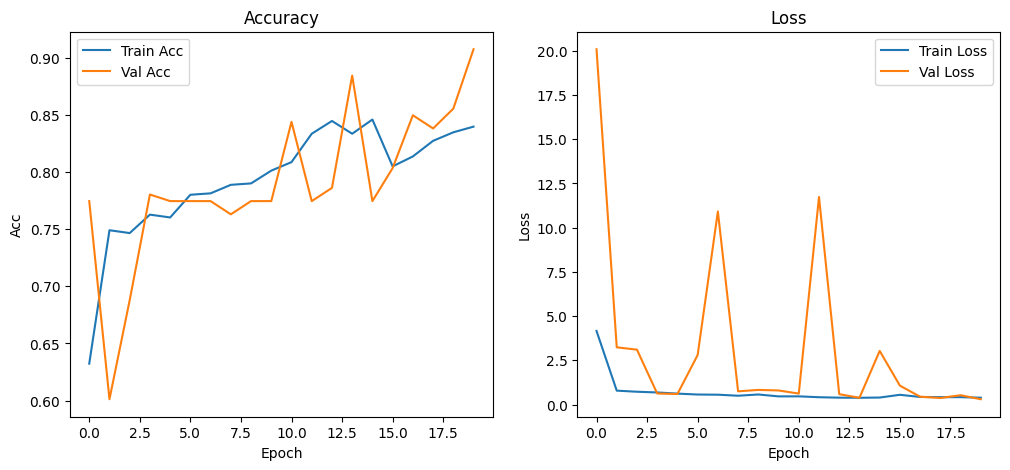

In [29]:
# GRAFICE: ACCURACY și LOSS

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [30]:
# ===================== 12. ANOMALY DETECTION (Normal vs Abnormal) =====================

normal_candidate = None
if "Healthy" in data_df["diagnosis"].unique():
    normal_candidate = "Healthy"
elif "Normal" in data_df["diagnosis"].unique():
    normal_candidate = "Normal"

if normal_candidate is None:
    print("Nu există etichetă Healthy/Normal în date. Alege manual o clasă 'normală'.")
    print("Clase disponibile:", classes)
else:
    print("Folosim clasa normală:", normal_candidate)
    normal_idx = le.transform([normal_candidate])[0]

    # 0 = Normal, 1 = Abnormal
    y_test_binary = (y_test != normal_idx).astype(int)
    y_pred_binary = (y_pred_int != normal_idx).astype(int)

    print(classification_report(
        y_test_binary,
        y_pred_binary,
        target_names=["Normal", "Abnormal"],
        zero_division=0
    ))


Folosim clasa normală: Healthy
              precision    recall  f1-score   support

      Normal       0.88      0.88      0.88        16
    Abnormal       0.99      0.99      0.99       157

    accuracy                           0.98       173
   macro avg       0.93      0.93      0.93       173
weighted avg       0.98      0.98      0.98       173



In [33]:
model.save("lung_cnn_model.keras")
print("Model salvat în format Keras!")


Model salvat în format Keras!
